## Setup and Data Loading

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Display settings
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [2]:
df = pd.read_csv('ExerciseData.csv')
df

,Experiment,V,Cr,Mg,Fe,Co,Ni,Cu,S,Se,P,Voltage,Time,Overpotential V at 50.0 mA/cm2
0,exp1,5,5,25,0,5,0,10,15,0,5,-1.2,90,-0.5917
1,exp2,0,5,5,10,10,0,0,15,10,0,-1.2,60,-0.7847
2,exp3,5,10,10,0,10,0,10,5,10,5,-1.3,120,-0.6637
3,exp4,5,0,0,25,0,10,0,10,10,10,-1.4,90,-0.5297
4,exp5,0,10,0,0,5,15,5,10,10,15,-1.3,120,-0.7347
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,exp581,0,0,0,5,0,25,10,30,0,0,-1.5,180,NaN
496,exp582,0,30,0,0,0,20,0,0,0,20,-1.0,180,-0.6837
497,exp583,0,0,0,0,0,5,45,0,0,20,-1.0,60,-0.5877
498,exp584,0,0,0,0,0,25,25,0,0,20,-1.0,180,-0.4137


## Part 1: Preparing the Training, Validation, and Test Dataset

### Task 1.1: Visualize η in 11-dimensional space

The overpotential η is a function of 11 variables: V, Cr, Mg, Fe, Co, Ni, Cu, S, Se, P, voltage, time.  
We'll create multiple visualizations to explore this high-dimensional space.

In [3]:
print("Columns in dataset:")
print(df.columns.tolist())

feature_columns = ['V', 'Cr', 'Mg', 'Fe', 'Co', 'Ni', 'Cu', 'S', 'Se', 'P', 'Voltage', 'Time']
target_column = 'Overpotential V at 50.0 mA/cm2'

Columns in dataset:
['Experiment', 'V', 'Cr', 'Mg', 'Fe', 'Co', 'Ni', 'Cu', 'S', 'Se', 'P', 'Voltage', 'Time', 'Overpotential V at 50.0 mA/cm2']


In [4]:
# Calculate absolute value of overpotential
df['abs_eta'] = np.abs(df[target_column])

# Create "good" vs "bad" catalyst labels
df['catalyst_quality'] = df['abs_eta'].apply(lambda x: 'good' if x < 0.6 else 'bad')

print(f"Distribution of η:")
print(f"Mean: {df[target_column].mean():.4f}")
print(f"Std: {df[target_column].std():.4f}")
print(f"Min: {df[target_column].min():.4f}")
print(f"Max: {df[target_column].max():.4f}")

Distribution of η:
Mean: -0.6431
Std: 0.1606
Min: -1.0047
Max: -0.2427


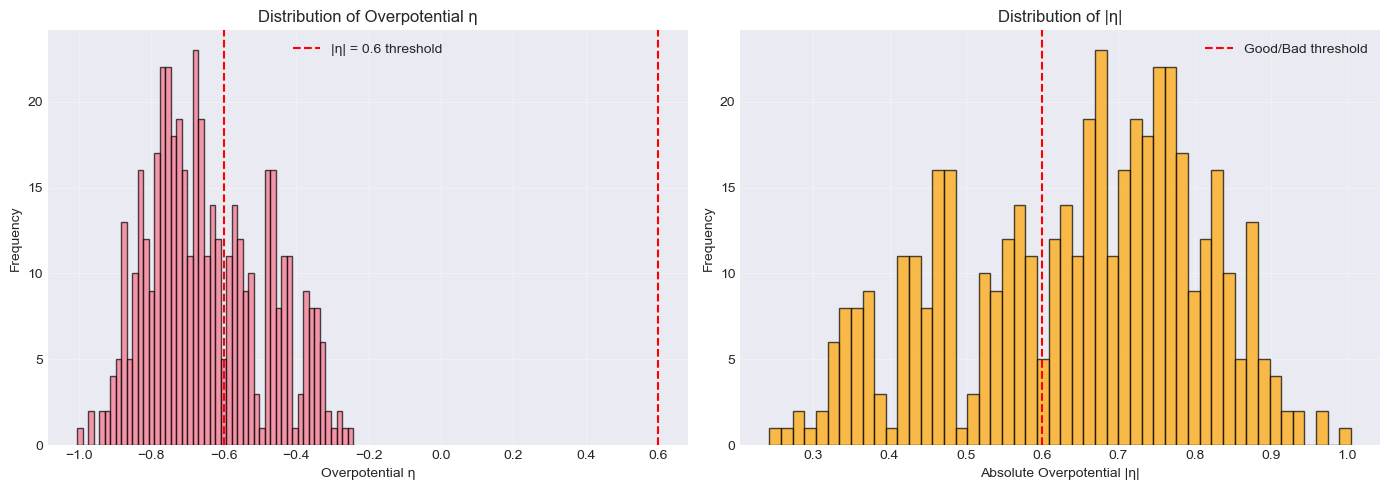

In [5]:
# Visualization 1: Distribution of overpotential η
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Original η distribution
axes[0].hist(df[target_column], bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(x=-0.6, color='r', linestyle='--', label='|η| = 0.6 threshold')
axes[0].axvline(x=0.6, color='r', linestyle='--')
axes[0].set_xlabel('Overpotential η')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Overpotential η')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Absolute value |η| distribution
axes[1].hist(df['abs_eta'], bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[1].axvline(x=0.6, color='r', linestyle='--', label='Good/Bad threshold')
axes[1].set_xlabel('Absolute Overpotential |η|')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of |η|')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

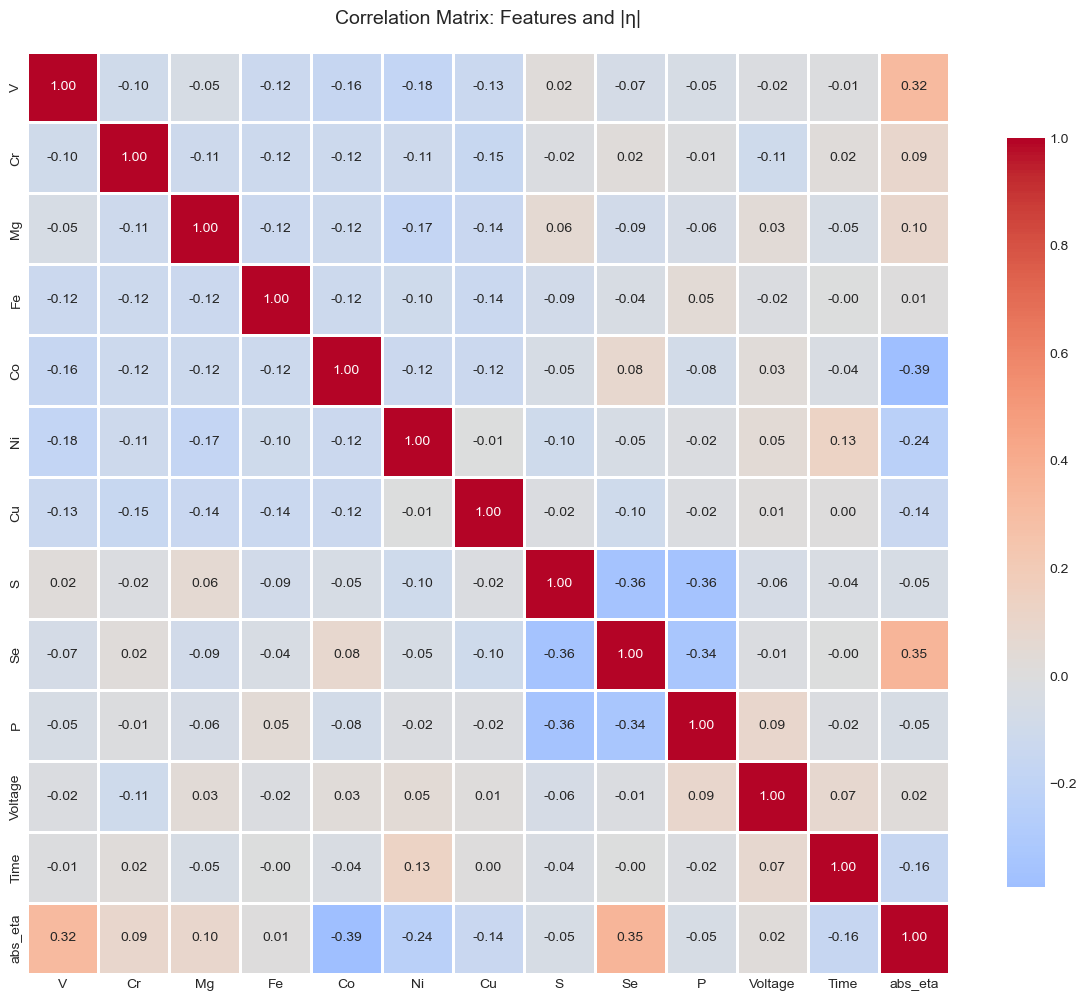


Correlations with |η| (sorted by absolute value):
Co        -0.392959
Se         0.351707
V          0.316310
Ni        -0.240310
Time      -0.163109
Cu        -0.142939
Mg         0.096102
Cr         0.091455
S         -0.052668
P         -0.047347
Voltage    0.022833
Fe         0.005567
Name: abs_eta, dtype: float64


In [6]:
# Visualization 2: Correlation heatmap of features with |η|
correlation_data = df[feature_columns + ['abs_eta']].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_data, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix: Features and |η|', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

# Show correlations with |η| sorted by absolute value
print("\nCorrelations with |η| (sorted by absolute value):")
eta_corr = correlation_data['abs_eta'].drop('abs_eta').sort_values(key=abs, ascending=False)
print(eta_corr)

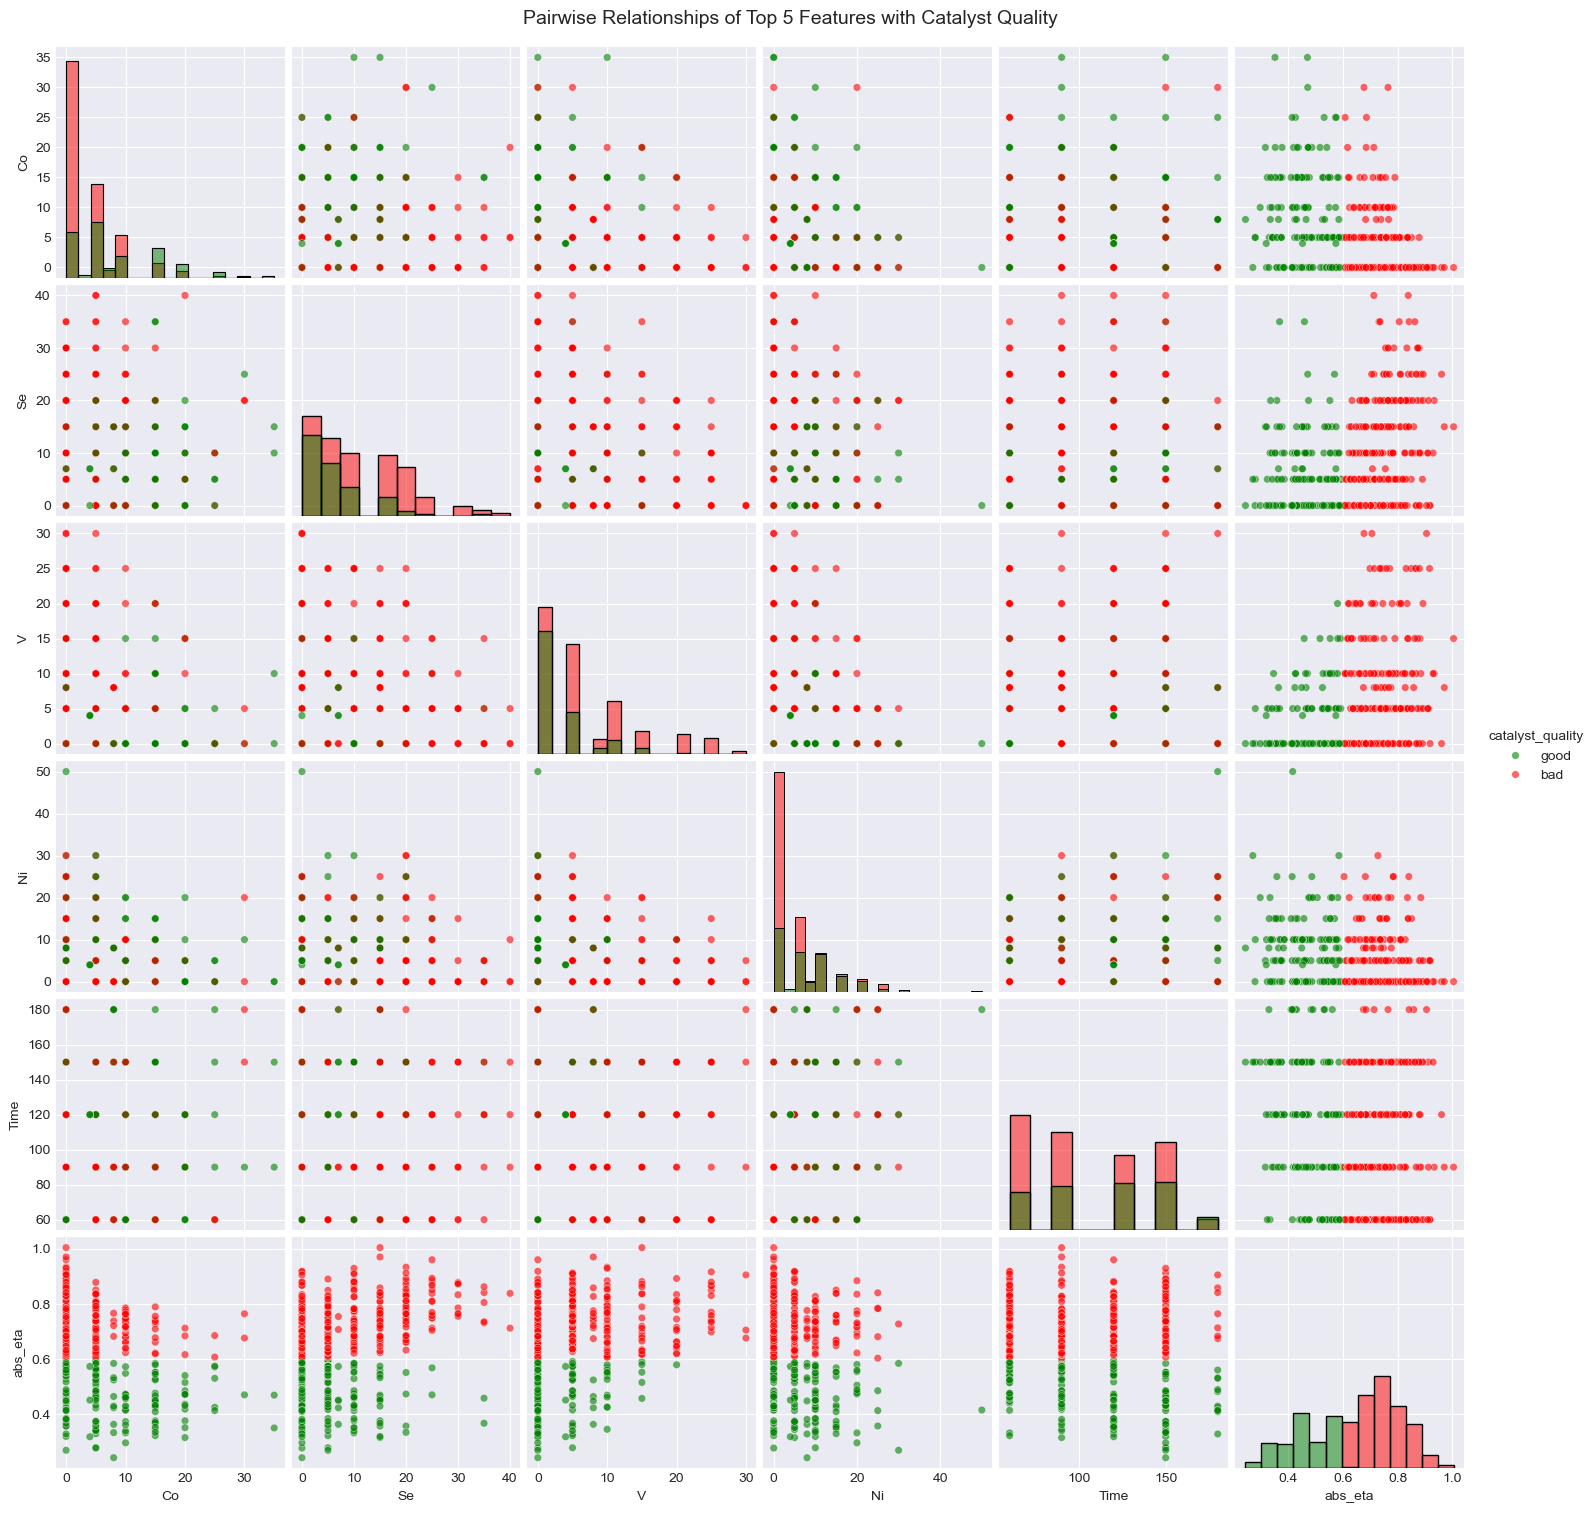

In [7]:
# Visualization 3: Pairwise scatter plots for top correlated features
top_features = eta_corr.head(5).index.tolist()
plot_data = df[top_features + ['abs_eta', 'catalyst_quality']].copy()

# Create pairplot
pair_plot = sns.pairplot(plot_data, hue='catalyst_quality', 
                         palette={'good': 'green', 'bad': 'red'},
                         plot_kws={'alpha': 0.6, 's': 30},
                         diag_kind='hist')
pair_plot.fig.suptitle('Pairwise Relationships of Top 5 Features with Catalyst Quality', 
                        y=1.01, fontsize=14)
plt.show()

In [8]:
# Visualization 4: PCA for dimensionality reduction to 2D/3D
from sklearn.decomposition import PCA

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[feature_columns])

# PCA to 2 components
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_scaled)

# PCA to 3 components
pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(X_scaled)

print(f"\nPCA 2D - Explained variance: {pca_2d.explained_variance_ratio_.sum():.2%}")
print(f"PC1: {pca_2d.explained_variance_ratio_[0]:.2%}, PC2: {pca_2d.explained_variance_ratio_[1]:.2%}")
print(f"\nPCA 3D - Explained variance: {pca_3d.explained_variance_ratio_.sum():.2%}")


PCA 2D - Explained variance: 24.43%
PC1: 12.52%, PC2: 11.91%

PCA 3D - Explained variance: 35.10%


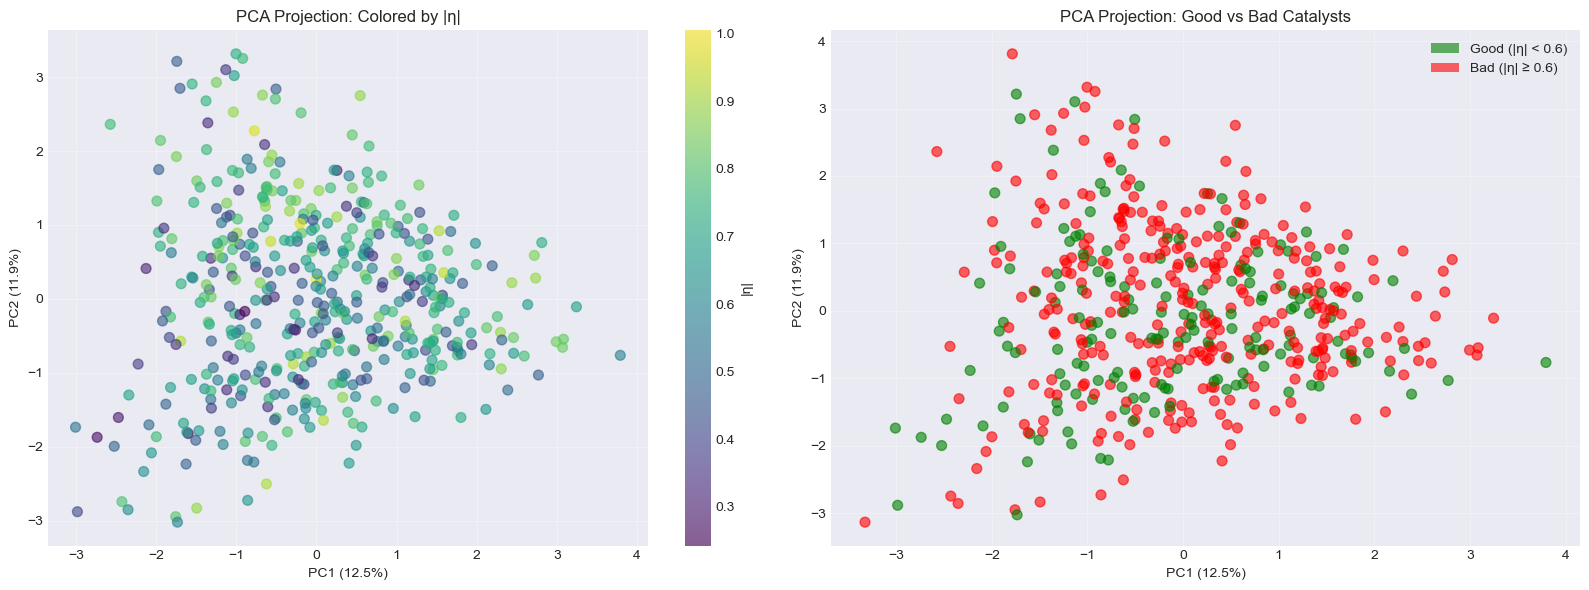

In [9]:
# Plot 2D PCA
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Colored by |η|
scatter1 = axes[0].scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], 
                           c=df['abs_eta'], cmap='viridis', s=50, alpha=0.6)
axes[0].set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.1%})')
axes[0].set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.1%})')
axes[0].set_title('PCA Projection: Colored by |η|')
plt.colorbar(scatter1, ax=axes[0], label='|η|')
axes[0].grid(True, alpha=0.3)

# Colored by catalyst quality
colors = ['green' if q == 'good' else 'red' for q in df['catalyst_quality']]
axes[1].scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], c=colors, s=50, alpha=0.6)
axes[1].set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.1%})')
axes[1].set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.1%})')
axes[1].set_title('PCA Projection: Good vs Bad Catalysts')
axes[1].grid(True, alpha=0.3)

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='green', alpha=0.6, label='Good (|η| < 0.6)'),
                   Patch(facecolor='red', alpha=0.6, label='Bad (|η| ≥ 0.6)')]
axes[1].legend(handles=legend_elements, loc='best')

plt.tight_layout()
plt.show()

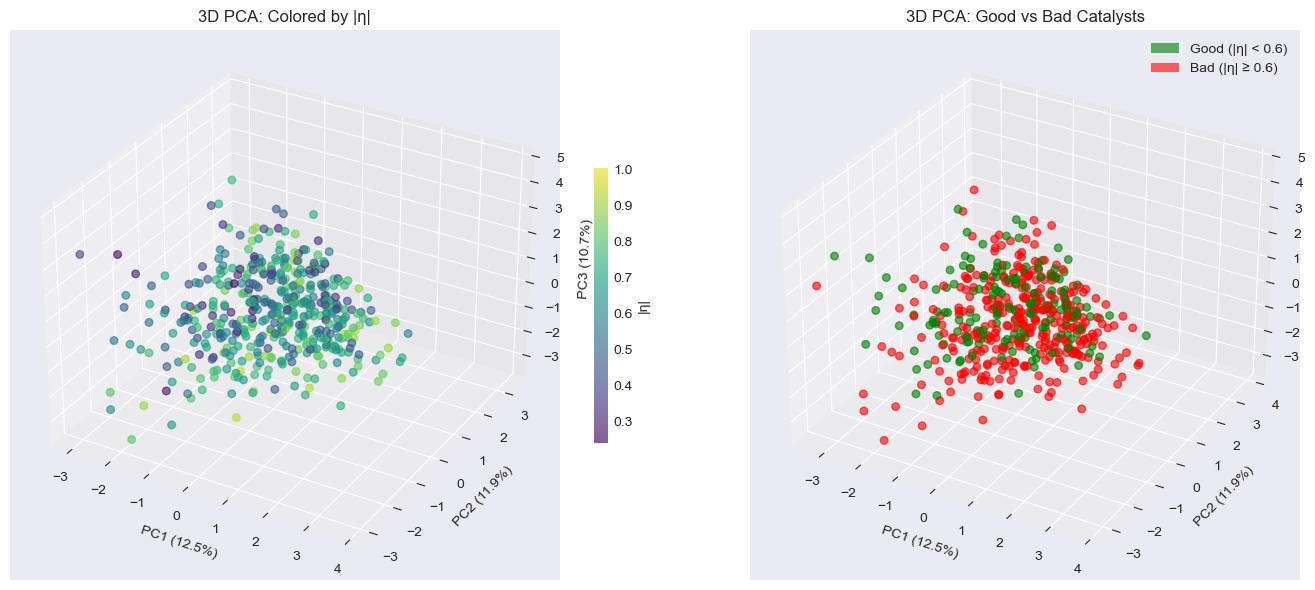

In [10]:
# 3D PCA visualization
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(14, 6))

# 3D plot colored by |η|
ax1 = fig.add_subplot(121, projection='3d')
scatter1 = ax1.scatter(X_pca_3d[:, 0], X_pca_3d[:, 1], X_pca_3d[:, 2],
                       c=df['abs_eta'], cmap='viridis', s=30, alpha=0.6)
ax1.set_xlabel(f'PC1 ({pca_3d.explained_variance_ratio_[0]:.1%})')
ax1.set_ylabel(f'PC2 ({pca_3d.explained_variance_ratio_[1]:.1%})')
ax1.set_zlabel(f'PC3 ({pca_3d.explained_variance_ratio_[2]:.1%})')
ax1.set_title('3D PCA: Colored by |η|')
plt.colorbar(scatter1, ax=ax1, label='|η|', shrink=0.5)

# 3D plot colored by quality
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(X_pca_3d[:, 0], X_pca_3d[:, 1], X_pca_3d[:, 2],
            c=colors, s=30, alpha=0.6)
ax2.set_xlabel(f'PC1 ({pca_3d.explained_variance_ratio_[0]:.1%})')
ax2.set_ylabel(f'PC2 ({pca_3d.explained_variance_ratio_[1]:.1%})')
ax2.set_zlabel(f'PC3 ({pca_3d.explained_variance_ratio_[2]:.1%})')
ax2.set_title('3D PCA: Good vs Bad Catalysts')
ax2.legend(handles=legend_elements, loc='best')

plt.tight_layout()
plt.show()

### Task 1.2: Split Dataset (70% Train, 15% Validation, 15% Test)

In [11]:
# Prepare features (X) and target (y)
X = df[feature_columns].values
y = (df['abs_eta'] < 0.6).astype(int)  # 1 = good, 0 = bad

In [12]:
# First split: 70% train, 30% temp (which will be split into val and test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

# Second split: 15% validation, 15% test (50-50 split of the 30%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

## Part 2: Predicting "Good" Catalysts Using Scikit-Learn

### Task 1.3: Calculate Percentage of Good vs Bad Catalysts

In [13]:
# Calculate percentages in full dataset
total_samples = len(df)
good_count = (df['catalyst_quality'] == 'good').sum()
bad_count = (df['catalyst_quality'] == 'bad').sum()

good_percentage = (good_count / total_samples) * 100
bad_percentage = (bad_count / total_samples) * 100

print(f"Good catalysts (|η| < 0.6): {good_count} ({good_percentage:.2f}%)")
print(f"Bad catalysts (|η| ≥ 0.6): {bad_count} ({bad_percentage:.2f}%)")

Good catalysts (|η| < 0.6): 165 (33.00%)
Bad catalysts (|η| ≥ 0.6): 335 (67.00%)


### Task 1.4: Train Random Forest with Default Settings

In [14]:
# Train Random Forest with default parameters
rf_default = RandomForestClassifier(random_state=42)
rf_default.fit(X_train, y_train)

# Make predictions on all datasets
y_train_pred = rf_default.predict(X_train)
y_val_pred = rf_default.predict(X_val)
y_test_pred = rf_default.predict(X_test)

# Calculate metrics for each dataset
def calculate_metrics(y_true, y_pred, dataset_name):
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    return precision, recall, f1

# Calculate metrics
train_metrics = calculate_metrics(y_train, y_train_pred, "Training")
val_metrics = calculate_metrics(y_val, y_val_pred, "Validation")
test_metrics = calculate_metrics(y_test, y_test_pred, "Test")

# Create results dataframe
results_default = pd.DataFrame({
    'Dataset': ['Training', 'Validation', 'Test'],
    'Precision': [train_metrics[0], val_metrics[0], test_metrics[0]],
    'Recall': [train_metrics[1], val_metrics[1], test_metrics[1]],
    'F1 Score': [train_metrics[2], val_metrics[2], test_metrics[2]]
})

print("Summary Table:")
display(results_default)

Summary Table:


,Dataset,Precision,Recall,F1 Score
0,Training,1.000000,1.00,1.000000
1,Validation,0.666667,0.48,0.558140
2,Test,0.705882,0.50,0.585366


### Task 1.5: Hyperparameter Tuning (4+ Combinations)

In [15]:
# Define hyperparameter combinations to try
hyperparameter_combinations = [
    # Combination 1: Default parameters
    {'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 2},
    
    # Combination 2: More trees, shallower depth
    {'n_estimators': 200, 'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 3},
    
    # Combination 3: Deeper trees with regularization
    {'n_estimators': 150, 'max_depth': 25, 'min_samples_split': 2, 'min_samples_leaf': 1},
    
    # Combination 4: Balanced approach with class weighting
    {'n_estimators': 300, 'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 4, 
     'class_weight': 'balanced'},
    
    # Combination 5: Aggressive with class weighting and regularization
    {'n_estimators': 500, 'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 4, 
     'class_weight': 'balanced', 'max_leaf_nodes': 50, 'min_impurity_decrease': 0.02},
]

# Store results
tuning_results = []

print(f"\nTesting {len(hyperparameter_combinations)} hyperparameter combinations...\n")

for i, params in enumerate(hyperparameter_combinations, 1):
    print(f"Combination {i}: {params}")
    
    # Train model with current hyperparameters
    rf = RandomForestClassifier(**params, random_state=42)
    rf.fit(X_train, y_train)
    
    # Predict on all datasets
    y_train_pred = rf.predict(X_train)
    y_val_pred = rf.predict(X_val)
    y_test_pred = rf.predict(X_test)
    
    # Calculate metrics for each dataset
    train_prec = precision_score(y_train, y_train_pred)
    train_rec = recall_score(y_train, y_train_pred)
    train_f1 = f1_score(y_train, y_train_pred)
    
    val_prec = precision_score(y_val, y_val_pred)
    val_rec = recall_score(y_val, y_val_pred)
    val_f1 = f1_score(y_val, y_val_pred)
    
    test_prec = precision_score(y_test, y_test_pred)
    test_rec = recall_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred)
    
    # Calculate averaged metrics across all datasets
    avg_prec = np.mean([train_prec, val_prec, test_prec])
    avg_rec = np.mean([train_rec, val_rec, test_rec])
    avg_f1 = np.mean([train_f1, val_f1, test_f1])
    
    # Store results
    tuning_results.append({
        'Combination': i,
        'n_estimators': params['n_estimators'],
        'max_depth': params['max_depth'],
        'min_samples_split': params['min_samples_split'],
        'min_samples_leaf': params['min_samples_leaf'],
        'class_weight': params.get('class_weight', None),
        'max_leaf_nodes': params.get('max_leaf_nodes', None),
        'min_impurity_decrease': params.get('min_impurity_decrease', 0.0),
        'Train_Precision': train_prec,
        'Train_Recall': train_rec,
        'Train_F1': train_f1,
        'Val_Precision': val_prec,
        'Val_Recall': val_rec,
        'Val_F1': val_f1,
        'Test_Precision': test_prec,
        'Test_Recall': test_rec,
        'Test_F1': test_f1,
        'Avg_Precision': avg_prec,
        'Avg_Recall': avg_rec,
        'Avg_F1': avg_f1
    })

# Create results dataframe
tuning_df = pd.DataFrame(tuning_results)

print("\nHyperparameter Tuning Results:")
display(tuning_df)


Testing 5 hyperparameter combinations...

Combination 1: {'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 2}
Combination 2: {'n_estimators': 200, 'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 3}
Combination 3: {'n_estimators': 150, 'max_depth': 25, 'min_samples_split': 2, 'min_samples_leaf': 1}
Combination 4: {'n_estimators': 300, 'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 4, 'class_weight': 'balanced'}
Combination 5: {'n_estimators': 500, 'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 4, 'class_weight': 'balanced', 'max_leaf_nodes': 50, 'min_impurity_decrease': 0.02}

Hyperparameter Tuning Results:


,Combination,n_estimators,max_depth,min_samples_split,min_samples_leaf,class_weight,max_leaf_nodes,min_impurity_decrease,Train_Precision,Train_Recall,Train_F1,Val_Precision,Val_Recall,Val_F1,Test_Precision,Test_Recall,Test_F1,Avg_Precision,Avg_Recall,Avg_F1
0,1,100,20,5,2,None,NaN,0.00,0.990826,0.931034,0.960000,0.619048,0.52,0.565217,0.705882,0.500000,0.585366,0.771919,0.650345,0.703528
1,2,200,15,3,3,None,NaN,0.00,0.972477,0.913793,0.942222,0.647059,0.44,0.523810,0.750000,0.500000,0.600000,0.789845,0.617931,0.688677
2,3,150,25,2,1,None,NaN,0.00,1.000000,1.000000,1.000000,0.647059,0.44,0.523810,0.705882,0.500000,0.585366,0.784314,0.646667,0.703058
3,4,300,12,2,4,balanced,NaN,0.00,0.853846,0.956897,0.902439,0.680000,0.68,0.680000,0.640000,0.666667,0.653061,0.724615,0.767854,0.745167
4,5,500,12,2,4,balanced,50.0,0.02,0.668919,0.853448,0.750000,0.542857,0.76,0.633333,0.600000,0.625000,0.612245,0.603925,0.746149,0.665193


In [16]:
# Identify the best hyperparameter combination based on validation F1 score
best_idx = tuning_df['Val_F1'].idxmax()
best_combo = tuning_df.loc[best_idx]

### Task 1.6: Permutation Feature Importance (With and Without Normalization)

#### Part A: PFI Without Normalization

In [17]:
# Train Random Forest on non-normalized data (using best hyperparameters)
best_params = {
    'n_estimators': int(best_combo['n_estimators']),
    'max_depth': int(best_combo['max_depth']) if pd.notna(best_combo['max_depth']) else None,
    'min_samples_split': int(best_combo['min_samples_split']),
    'min_samples_leaf': int(best_combo['min_samples_leaf']),
    'random_state': 42
}

rf_no_norm = RandomForestClassifier(**best_params)
rf_no_norm.fit(X_train, y_train)

# Calculate permutation importance
pfi_no_norm = permutation_importance(
    rf_no_norm, X_test, y_test, 
    n_repeats=30, 
    random_state=42, 
    scoring='f1'
)

# Create results dataframe
pfi_no_norm_df = pd.DataFrame({
    'Feature': feature_columns,
    'Importance_Mean': pfi_no_norm.importances_mean,
    'Importance_Std': pfi_no_norm.importances_std
}).sort_values('Importance_Mean', ascending=False)

pfi_no_norm_df['Rank'] = range(1, len(pfi_no_norm_df) + 1)

print("\nPermutation Feature Importance (No Normalization):")
display(pfi_no_norm_df)

print("\nTop 5 Most Important Features (No Normalization):")
for idx, row in pfi_no_norm_df.head(5).iterrows():
    print(f"  {int(row['Rank'])}. {row['Feature']}: {row['Importance_Mean']:.4f} (±{row['Importance_Std']:.4f})")


Permutation Feature Importance (No Normalization):


,Feature,Importance_Mean,Importance_Std,Rank
4,Co,0.238122,0.078254,1
8,Se,0.155201,0.077869,2
0,V,0.126722,0.089177,3
5,Ni,0.086848,0.047118,4
6,Cu,0.046413,0.035059,5
11,Time,0.044433,0.026072,6
7,S,0.015718,0.016803,7
10,Voltage,0.015403,0.022618,8
1,Cr,0.014164,0.034557,9
3,Fe,0.012996,0.034189,10



Top 5 Most Important Features (No Normalization):
  1. Co: 0.2381 (±0.0783)
  2. Se: 0.1552 (±0.0779)
  3. V: 0.1267 (±0.0892)
  4. Ni: 0.0868 (±0.0471)
  5. Cu: 0.0464 (±0.0351)


#### Part B: PFI With Normalization

In [18]:
# Normalize the data using StandardScaler
scaler_pfi = StandardScaler()
X_train_scaled = scaler_pfi.fit_transform(X_train)
X_test_scaled = scaler_pfi.transform(X_test)

# Train Random Forest on normalized data
rf_with_norm = RandomForestClassifier(**best_params)
rf_with_norm.fit(X_train_scaled, y_train)

# Calculate permutation importance
pfi_with_norm = permutation_importance(
    rf_with_norm, X_test_scaled, y_test, 
    n_repeats=30, 
    random_state=42, 
    scoring='f1'
)

# Create results dataframe
pfi_with_norm_df = pd.DataFrame({
    'Feature': feature_columns,
    'Importance_Mean': pfi_with_norm.importances_mean,
    'Importance_Std': pfi_with_norm.importances_std
}).sort_values('Importance_Mean', ascending=False)

pfi_with_norm_df['Rank'] = range(1, len(pfi_with_norm_df) + 1)

print("\nPermutation Feature Importance (With Normalization):")
display(pfi_with_norm_df)

print("\nTop 5 Most Important Features (With Normalization):")
for idx, row in pfi_with_norm_df.head(5).iterrows():
    print(f"  {int(row['Rank'])}. {row['Feature']}: {row['Importance_Mean']:.4f} (±{row['Importance_Std']:.4f})")


Permutation Feature Importance (With Normalization):


,Feature,Importance_Mean,Importance_Std,Rank
4,Co,0.237772,0.078266,1
8,Se,0.155201,0.077869,2
0,V,0.145050,0.087450,3
5,Ni,0.084266,0.048944,4
6,Cu,0.046413,0.035059,5
11,Time,0.044433,0.026072,6
3,Fe,0.018674,0.035828,7
7,S,0.015718,0.016803,8
10,Voltage,0.015403,0.022618,9
1,Cr,0.014164,0.034557,10



Top 5 Most Important Features (With Normalization):
  1. Co: 0.2378 (±0.0783)
  2. Se: 0.1552 (±0.0779)
  3. V: 0.1450 (±0.0875)
  4. Ni: 0.0843 (±0.0489)
  5. Cu: 0.0464 (±0.0351)


#### Part C: Comparison - No Normalization vs With Normalization

In [19]:
# Compare rankings
comparison_df = pd.DataFrame({
    'Feature': feature_columns,
    'No_Norm_Importance': pfi_no_norm_df.set_index('Feature').loc[feature_columns, 'Importance_Mean'].values,
    'No_Norm_Rank': pfi_no_norm_df.set_index('Feature').loc[feature_columns, 'Rank'].values,
    'With_Norm_Importance': pfi_with_norm_df.set_index('Feature').loc[feature_columns, 'Importance_Mean'].values,
    'With_Norm_Rank': pfi_with_norm_df.set_index('Feature').loc[feature_columns, 'Rank'].values
})

comparison_df['Rank_Change'] = comparison_df['No_Norm_Rank'] - comparison_df['With_Norm_Rank']
display(comparison_df.sort_values('With_Norm_Rank'))

print("Top 5 Most Important Variables")
print("\nWithout Normalization:")
for i, feat in enumerate(pfi_no_norm_df.head(5)['Feature'].values, 1):
    print(f"  {i}. {feat}")

print("\nWith Normalization:")
for i, feat in enumerate(pfi_with_norm_df.head(5)['Feature'].values, 1):
    print(f"  {i}. {feat}")

,Feature,No_Norm_Importance,No_Norm_Rank,With_Norm_Importance,With_Norm_Rank,Rank_Change
4,Co,0.238122,1,0.237772,1,0
8,Se,0.155201,2,0.155201,2,0
0,V,0.126722,3,0.145050,3,0
5,Ni,0.086848,4,0.084266,4,0
6,Cu,0.046413,5,0.046413,5,0
11,Time,0.044433,6,0.044433,6,0
3,Fe,0.012996,10,0.018674,7,3
7,S,0.015718,7,0.015718,8,-1
10,Voltage,0.015403,8,0.015403,9,-1
1,Cr,0.014164,9,0.014164,10,-1


Top 5 Most Important Variables

Without Normalization:
  1. Co
  2. Se
  3. V
  4. Ni
  5. Cu

With Normalization:
  1. Co
  2. Se
  3. V
  4. Ni
  5. Cu


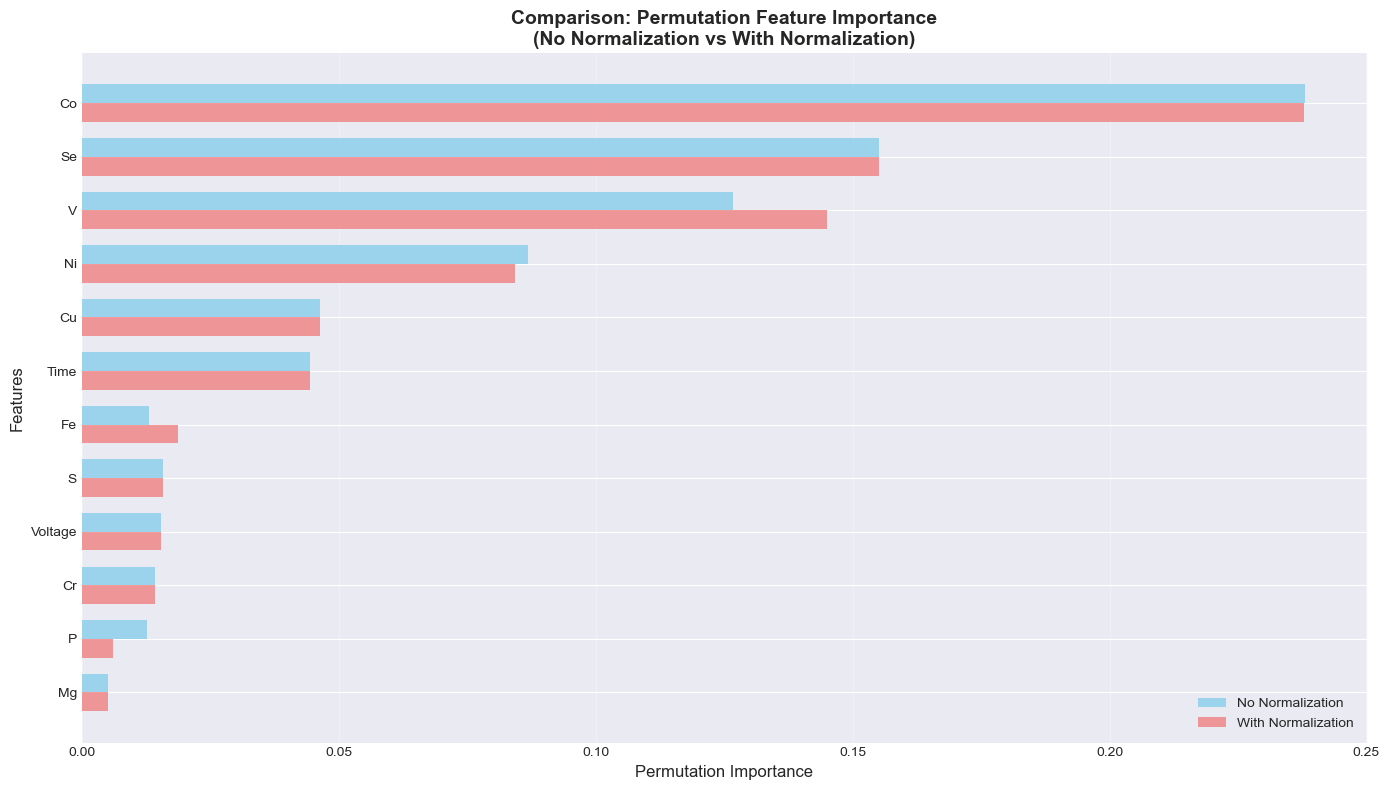

In [20]:
# Side-by-side comparison
fig, ax = plt.subplots(figsize=(14, 8))

x = np.arange(len(feature_columns))
width = 0.35

# Sort by with_norm importance for better visualization
sorted_features = pfi_with_norm_df['Feature'].values
no_norm_sorted = [comparison_df[comparison_df['Feature'] == f]['No_Norm_Importance'].values[0] 
                  for f in sorted_features]
with_norm_sorted = [comparison_df[comparison_df['Feature'] == f]['With_Norm_Importance'].values[0] 
                    for f in sorted_features]

bars1 = ax.barh(x - width/2, no_norm_sorted, width, label='No Normalization', alpha=0.8, color='skyblue')
bars2 = ax.barh(x + width/2, with_norm_sorted, width, label='With Normalization', alpha=0.8, color='lightcoral')

ax.set_ylabel('Features', fontsize=12)
ax.set_xlabel('Permutation Importance', fontsize=12)
ax.set_title('Comparison: Permutation Feature Importance\n(No Normalization vs With Normalization)', 
             fontsize=14, fontweight='bold')
ax.set_yticks(x)
ax.set_yticklabels(sorted_features)
ax.invert_yaxis()
ax.legend()
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()